# 미니 프로젝트: 시계열 분류

  | 평가 문항 | 상세 기준 |
  |---------|---------|
  | 1. 시계열 데이터를 정상 데이터로 만드는 과정에서 주요한 시각화 과정을 확인하였는가? | 학습 단계별 결과가 제대로 출력되었으며 로그 변환, 계절성 제거, 특성 중요도 시각화를 통해 적용이 잘 되었는지 확인하였다. |
  | 2. 시계열 데이터를 분석하는 통계적 지표와 분류 모델의 성능을 확인하는 지표를 확인하였는가? | 	정상성을 확인하는 지표에서 ADF와 P-value를 확인하고 Classification report를 확인해보았다. |
  | 3. 시계열 분류 모델 3가지가 성공적으로 작동하는가? | 	Logistic Regression, RandomForest, XGBoost의 모델 학습 및 테스트가 정상적으로 수행되고, 결과값을 얻었다. |

# Air Passengers

## 1.데이터 준비

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# air passengers 데이터 불러오기
ap = pd.read_csv('/content/AirPassengers.csv')

In [3]:
ap.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
# 실습과 관련 없는 'Month' 컬럼 삭제
ap = ap.drop('Month', axis=1)

In [49]:
ap.head()

,#Passengers
0,112
1,118
2,132
3,129
4,121


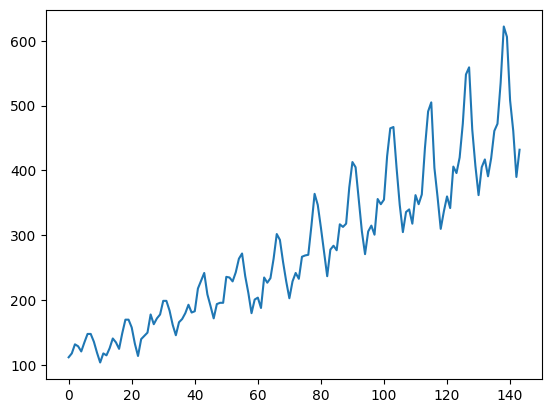

In [7]:
# 데이터 시각화
plt.figure()
plt.plot(ap)
plt.show()

## 2.분산을 일정하게 만들기: 로그 변환

In [8]:
log_transformed = np.log(ap)
log_transformed

,#Passengers
0,4.718499
1,4.770685
2,4.882802
3,4.859812
4,4.795791
...,...
139,6.406880
140,6.230481
141,6.133398
142,5.966147


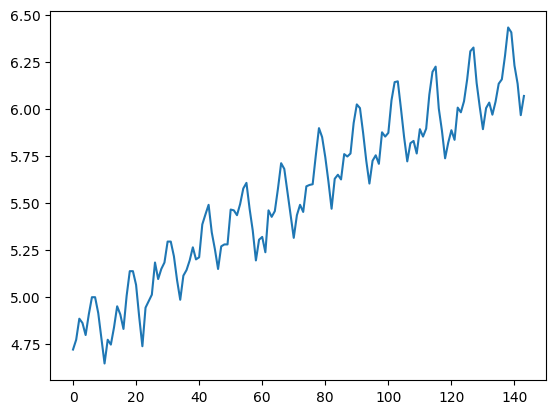

In [10]:
# 변환 후 시각화
plt.figure()
plt.plot(log_transformed)
plt.show()

## 3.차분을 통해 추세 제거

In [18]:
diffed = log_transformed.diff(1)[1:]
diffed

,#Passengers
1,0.052186
2,0.112117
3,-0.022990
4,-0.064022
5,0.109484
...,...
139,-0.026060
140,-0.176399
141,-0.097083
142,-0.167251


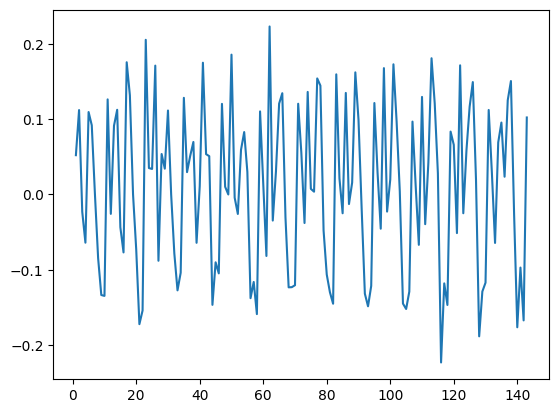

In [19]:
# 차분을 통한 추세 제거 후 시각화
# 커지는 분산과 증가하는 추세를 제거한 air passengers 데이터가 됨
plt.figure()
plt.plot(diffed)
plt.show()

## 4.계절 차분을 통한 계절성 제거
- AirPassengers 데이터는 12개월을 주기로 하는 계절성이 포함되어 있음
- 계절 차분을 통해서 계절성을 데이터에서 제거할 수 있음

In [21]:
seasonally_diffed = diffed.diff(12)

# 차분을 하면 데이터가 짧아지기 때문에 빈칸 제거
seasonally_diffed.dropna(inplace = True)

# 형태 확인
seasonally_diffed

,#Passengers
13,0.039164
14,0.000361
15,-0.020496
16,-0.012939
17,0.066148
...,...
139,-0.045934
140,0.012024
141,0.031830
142,-0.050082


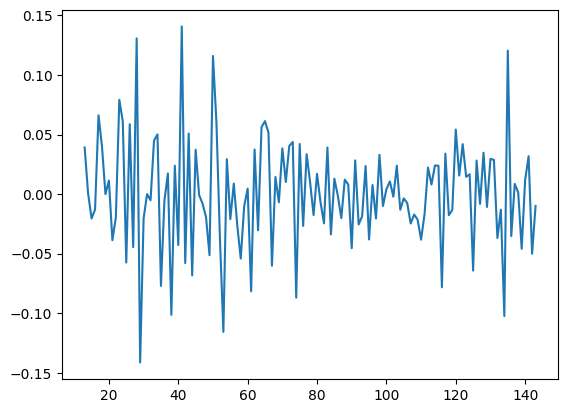

In [22]:
# 계절 차분 후 시각화
plt.figure()
plt.plot(seasonally_diffed)
plt.show()

## 5.검정을 통한 정상성 확인

### ADF 검정
- 가설
  - 귀무 가설: 시계열에 단위근이 존재한다. (단위근이 존재하면 비정상 시계열)
  - 대립 가설: 시계열이 정상성을 만족한다.
- 반환되는 값
  - `adf`(단위근 검정, Augmented Dickey Fuller): 정상성을 확인하기 위한 단위근 검정방법
  - `p-value`(유의 검정): 관찰된 데이터가 귀무가설이 맞다면 통계값 1이 실제로 관측된 값 이상일 확률
  - `usedlag`: 사용된 시차의 수
  - `nobs`: ADF 회귀 및 임계값 계산에 사용된 관측치의 수
  - `critical values`(임계값): 1%, 5% 및 10% 수준에서 테스트 통계에 대한 임계값
  - `icbest`: 0, 1, …, maxlag 값 중 lag 길이를 자동으로 결정할 때 autolag를 사용하며 이때 autolag를 none으로 지정할 수 있는데 none으로 지정하지 않는 경우 최대화된 정보 기준
- 결과
  - p-value가 0.0002로 대립 가설 채택. 정상성임을 확인함

In [136]:
from statsmodels.tsa.stattools import adfuller

def adf_test(x, verbose=True): # adf검정을 위한 함수 정의
    stat, p_value, lags, nobs, crit, icb = adfuller(x) # adfuller 함수를 이용하면 6가지 output이 나옵니다.
    if verbose:
      print('ADF statistics')
      print(stat) # ADF 검정 통계량입니다.
      print('P-value')
      print(p_value) # P-value입니다.
    return p_value

In [25]:
# 계절차분까지 수행한 데이터로 adf 검정 수행
adf_test(seasonally_diffed)

ADF statistics
-4.4433249418311425
P-value
0.00024859123113838495


### KPSS 검정
- 가설
  - 귀무 가설: 시계열 과정이 정상적(stationary)이다.
  - 대립 가설: 시계열 과정이 비정상적(non-stationary)이다.
- 결과
  - p-value가 0.1로 귀무 가설 채택. 정상성임을 확인함

In [72]:
from statsmodels.tsa.stattools import kpss

def kpss_test(x): # adf검정을 위한 함수 정의
    kpss_outputs = kpss(x)
    print('KPSS statistics')
    print(kpss_outputs[0]) # KPSS 검정 통계량
    print('P-value')
    print(kpss_outputs[1]) # P-value

In [73]:
# 계절차분까지 수행한 데이터로 adf 검정 수행
kpss_test(seasonally_diffed)

KPSS statistics
0.07319096983125449
P-value
0.1


<ipython-input-72-1c938970fa98>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_outputs = kpss(x)


# Robot Execution Failures

## 1.데이터 준비

In [75]:
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, load_robot_execution_failures
from tsfresh import extract_features, select_features
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report

In [28]:
# robot exection failures 데이터 불러오기
download_robot_execution_failures()
timeseries, y = load_robot_execution_failures()

In [29]:
# 데이터셋 확인
timeseries # id, time을 제외하고 6개 column의 X변수가 나타납니다.

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0
...,...,...,...,...,...,...,...,...
1315,88,10,-10,2,39,-21,-24,5
1316,88,11,-11,2,38,-24,-22,6
1317,88,12,-12,3,23,-24,-24,5
1318,88,13,-13,4,26,-29,-27,5


In [30]:
# 데이터셋 확인
y # true/false가 제시되어 있습니다.

1      True
2      True
3      True
4      True
5      True
      ...  
84    False
85    False
86    False
87    False
88    False
Length: 88, dtype: bool

## 2.데이터 전처리
- 변수 6개 모두 ADF 검정을 통해 정상성을 확인함

### 정상성 확인

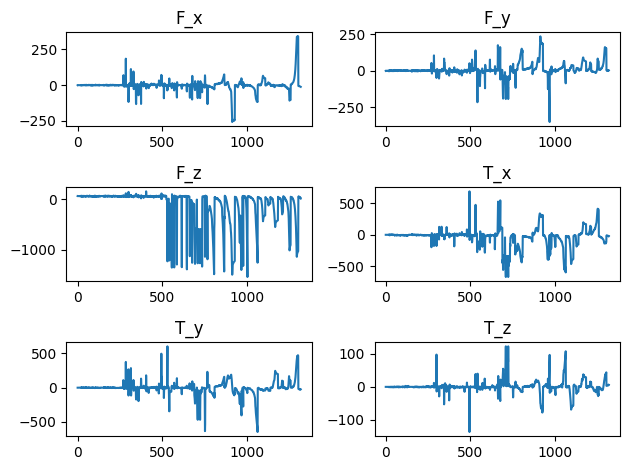

In [166]:
# 변수 시각화
fig, axes = plt.subplots(nrows=3, ncols=2)

for idx in range(0, 6):
  row = int(idx / 2)
  col = int(idx % 2)
  col_name = timeseries.columns[idx + 2]

  axes[row, col].set_title(col_name)
  axes[row, col].plot(timeseries[[col_name]])

plt.tight_layout()
plt.show()

In [157]:
# timeseries 각 변수에 대해 adf 검정 수행 (id, time 제외)
cols = []
for column in timeseries.columns[2:]: # id, time 제외
  p_value = adf_test(timeseries[[column]],
                     verbose=False)
  if p_value > 0.05:
    cols.append(column)

# adf 검정 결과
print('비정상 개수:', len(cols))

비정상 개수: 0


### 학습-테스트 데이터셋으로 분리

In [35]:
# 학습-테스트 데이터셋으로 분리하는 함수
def custom_classification_split(x,y,test_size=0.3):

    num_true = int(y.sum()*test_size)
    num_false = int((len(y)-y.sum())*test_size)

    id_list = y[y==False].head(num_false).index.to_list() + y[y==True].head(num_true).index.to_list()

    y_train = y.drop(id_list)
    y_test = y.iloc[id_list].sort_index()
    X_train = timeseries[~timeseries['id'].isin(id_list)]
    X_test = timeseries[timeseries['id'].isin(id_list)]

    return X_train, y_train, X_test, y_test

In [37]:
# 데이터셋 나누기
X_train, y_train, X_test, y_test = custom_classification_split(timeseries, y, 0.25)

### 피처 추출

In [36]:
settings = EfficientFCParameters()

In [38]:
comprehensive_features_train = extract_features(
                                    X_train,
                                    column_id="id",
                                    column_sort="time",
                                    default_fc_parameters=settings)

comprehensive_features_test = extract_features(
                                    X_test,
                                    column_id="id",
                                    column_sort="time",
                                    default_fc_parameters=settings)

Feature Extraction: 100%|██████████| 126/126 [00:07<00:00, 17.55it/s]


In [90]:
# 결과 확인
comprehensive_features_train.head(3)

,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,...,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
6,1.0,1.0,1.0,1.0,-15.0,39.0,1.714286,0.142857,0.153846,-1.0,...,0.974315,1.213008,1.732868,1.438883,1.863680,2.145842,2.163956,2.197225,0.0,0.714286
7,0.0,1.0,0.0,1.0,-13.0,21.0,0.928571,0.214286,-0.076923,-1.0,...,1.255482,1.494175,2.079442,1.043794,1.349792,1.666333,1.748067,1.831020,0.0,0.428571
8,1.0,0.0,1.0,1.0,-10.0,26.0,1.142857,-0.142857,0.192308,-1.0,...,1.494175,1.732868,2.079442,1.412745,2.138333,2.397895,2.302585,2.197225,0.0,1.285714


### 피처 선택
- 중요한 피처만 선택

In [88]:
filtered_features_train = select_features(comprehensive_features_train, y_train)
filtered_features_test = comprehensive_features_test[filtered_features_train.columns]

In [89]:
# 결과 확인
filtered_features_train.head(3)

,F_x__value_count__value_-1,F_x__range_count__max_1__min_-1,T_y__absolute_maximum,F_x__abs_energy,F_x__root_mean_square,F_z__variance,F_z__standard_deviation,F_x__mean_n_absolute_max__number_of_maxima_7,T_y__standard_deviation,F_y__root_mean_square,...,T_y__autocorrelation__lag_2,"F_z__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""var""","T_z__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.6","F_z__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.4",T_z__variation_coefficient,"F_z__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.2","T_x__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""var""",T_x__autocorrelation__lag_7,"F_z__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.4",F_x__minimum
6,6.0,7.0,6.0,39.0,1.612452,9.288889,3.047768,2.000000,2.080598,2.422120,...,-0.057021,6.026667,0.0,0.0000,-2.708013,1.100,0.693333,0.166159,8.222222,-3.0
7,8.0,13.0,7.0,21.0,1.183216,27.493333,5.243409,1.428571,1.892676,1.341641,...,0.501718,7.946667,0.0,5.6875,-6.633250,-1.000,2.746667,0.000279,5.040000,-3.0
8,8.0,9.0,6.0,26.0,1.316561,19.048889,4.364503,1.571429,2.445858,1.264911,...,-0.067322,24.586667,0.0,0.0000,-0.057881,-0.875,3.946667,0.116221,1.360000,-2.0


### 결측치 처리
- 결측치를 중앙값, 최댓값, 최솟값으로 채움
  - -inf -> min
  - +inf -> max
  - NaN -> median

In [39]:
impute(comprehensive_features_train)
impute(comprehensive_features_test)

/usr/local/lib/python3.10/dist-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,...,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
1,0.0,0.0,1.0,1.0,-14.0,14.0,0.142857,0.000000,-0.038462,-1.0,...,1.073543,1.440235,2.079442,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.0,0.000000
2,0.0,1.0,1.0,1.0,-13.0,25.0,1.000000,0.000000,-0.038462,-1.0,...,1.073543,1.494175,2.079442,0.937156,1.234268,1.540306,1.748067,1.831020,0.0,0.571429
3,0.0,0.0,1.0,1.0,-10.0,12.0,0.714286,0.000000,-0.038462,-1.0,...,1.386294,1.732868,2.079442,1.265857,1.704551,2.019815,2.163956,2.197225,0.0,0.571429
4,0.0,1.0,1.0,1.0,-6.0,16.0,1.214286,-0.071429,-0.038462,0.0,...,1.073543,1.494175,2.079442,1.156988,1.907284,2.397895,2.302585,2.197225,0.0,1.000000
5,0.0,0.0,0.0,1.0,-9.0,17.0,0.928571,-0.071429,0.038462,-1.0,...,0.900256,1.320888,2.079442,1.156988,1.863680,2.271869,2.302585,2.197225,0.0,0.857143
19,1.0,0.0,0.0,1.0,99.0,6109.0,13.928571,-1.928571,-1.730769,1.0,...,0.974315,1.494175,1.906155,1.230932,1.704551,2.019815,2.025326,2.043192,0.0,1.428571
20,1.0,0.0,1.0,1.0,155.0,34455.0,16.714286,-13.142857,7.576923,-1.0,...,1.386294,1.667462,2.079442,1.564957,2.022809,2.271869,2.302585,2.197225,0.0,2.571429
21,1.0,0.0,0.0,1.0,-171.0,16495.0,20.928571,1.785714,3.961538,-1.0,...,0.735622,0.735622,0.735622,1.303876,1.791759,2.271869,2.302585,2.197225,0.0,17.285714
22,1.0,0.0,0.0,1.0,102.0,12700.0,10.785714,-8.071429,4.500000,-1.0,...,0.562335,0.735622,1.732868,1.524707,2.138333,2.397895,2.302585,2.197225,0.0,5.428571
23,1.0,0.0,0.0,1.0,67.0,10593.0,15.142857,-7.000000,3.000000,-3.0,...,0.974315,1.255482,2.079442,1.519383,2.369382,2.397895,2.302585,2.197225,0.0,3.714286


In [91]:
impute(filtered_features_train)
impute(filtered_features_test)

/usr/local/lib/python3.10/dist-packages/tsfresh/utilities/dataframe_functions.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_impute.where(df_impute.values != np.PINF, other=col_to_max, inplace=True)
/usr/local/lib/python3.10/dist-packages/tsfresh/utilities/dataframe_functions.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_impute.where(df_impute.values != np.NINF, other=col_to_min, inplace=True)
/usr/local/lib/python3.10/dist-packages/tsfresh/utilities/dataframe_functions.py:170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

,F_x__value_count__value_-1,F_x__range_count__max_1__min_-1,T_y__absolute_maximum,F_x__abs_energy,F_x__root_mean_square,F_z__variance,F_z__standard_deviation,F_x__mean_n_absolute_max__number_of_maxima_7,T_y__standard_deviation,F_y__root_mean_square,...,T_y__autocorrelation__lag_2,"F_z__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""var""","T_z__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.6","F_z__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.4",T_z__variation_coefficient,"F_z__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.2","T_x__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""var""",T_x__autocorrelation__lag_7,"F_z__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.4",F_x__minimum
1,14.0,15.0,1.0,14.0,0.966092,1.448889,1.203698,1.000000,0.471405,0.930949,...,-0.538462,0.240000,0.000000,0.000000,-1.820890,0.083333,0.106667,-0.134615,0.000000,-1.0
2,7.0,13.0,5.0,25.0,1.290994,18.782222,4.333846,1.571429,2.054805,2.250926,...,0.050607,11.986667,0.000000,2.666667,-1.658312,-2.500000,7.386667,-0.057521,12.916667,-3.0
3,11.0,14.0,5.0,12.0,0.894427,21.315556,4.616877,1.000000,1.768867,1.632993,...,-0.051027,30.013333,0.000000,8.187500,-1.658312,0.272727,6.186667,-0.036058,9.142857,-1.0
4,5.0,10.0,6.0,16.0,1.032796,14.693333,3.833188,1.285714,2.669998,2.000000,...,-0.218780,9.546667,0.000000,1.000000,-1.788854,-1.375000,9.986667,-0.521862,8.138889,-2.0
5,9.0,13.0,5.0,17.0,1.064581,23.440000,4.841487,1.285714,2.039608,1.751190,...,0.002219,8.653333,0.000000,0.000000,-4.636809,0.625000,10.000000,0.361842,41.187500,-2.0
19,0.0,0.0,109.0,6109.0,20.180849,52.800000,7.266361,21.428571,36.929121,15.845083,...,-0.068661,99.160000,0.250000,6.250000,2.380476,-0.222222,5880.093333,-0.006871,10.250000,-12.0
20,4.0,9.0,374.0,34455.0,47.927028,244.666667,15.641824,30.571429,94.309278,27.227437,...,-0.029182,509.720000,0.000000,0.000000,4.669047,-5.625000,4136.573333,-0.126913,353.500000,-10.0
21,2.0,3.0,266.0,16495.0,33.161222,522.382222,22.855682,30.714286,75.078329,13.825098,...,-0.101211,1221.826667,0.500000,1.555556,4.693080,0.555556,4075.946667,-0.108766,1.555556,-119.0
22,2.0,3.0,284.0,12700.0,29.097537,64.640000,8.039900,20.000000,78.880895,18.399275,...,-0.107036,107.573333,0.555556,0.000000,-3.522486,-1.250000,3534.146667,-0.004949,5.555556,-5.0
23,0.0,0.0,111.0,10593.0,26.574424,83.955556,9.162726,25.142857,33.739920,5.882176,...,-0.400337,110.706667,0.000000,20.222222,3.807344,-0.363636,2566.426667,-0.089589,39.102041,-29.0


## 3.학습 및 결과 확인
- Random Forest와 XGBoost가 가장 성능이 뛰어남
- 정확도 결과
  - Logistic Regression: 0.61
  - Random Forest: 1.0
    - `true`
      - precision: 1.0
      - recall: 1.0
      - f1-score: 1.0
      - support: 16
    - `false`
      - precision: 1.0
      - recall: 1.0
      - f1-score: 1.0
      - support: 5
  - XGBoost: 1.0
    - `true`
      - precision: 1.0
      - recall: 1.0
      - f1-score: 1.0
      - support': 16
    - `false`
      - precision: 1.0
      - recall: 1.0
      - f1-score: 1.0
      - support: 5

### A. Logistic Regression

#### 학습 및 스코어 확인
1. 특징 추출 데이터: 0.5714285714285714
2. 특징 추출 및 중요한 특징 위주로 선택한 데이터: 0.6190476190476191

In [146]:
# (1) 특징 추출 데이터

# 학습
lr_clf = LogisticRegression(random_state=10)
lr_clf.fit(comprehensive_features_train, y_train)

# 스코어 확인
lr_clf.score(comprehensive_features_test, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5714285714285714

In [147]:
# (2) 특징 추출 및 중요한 특징 위주로 선택한 데이터

# 학습
lr_filtered_clf = LogisticRegression(random_state=10)
lr_filtered_clf.fit(filtered_features_train, y_train)

# 스코어 확인
lr_filtered_clf.score(filtered_features_test, y_test)

0.6190476190476191

#### 특성 중요도 확인
- 중요도 상위 5개 피처 시각화

<Axes: >

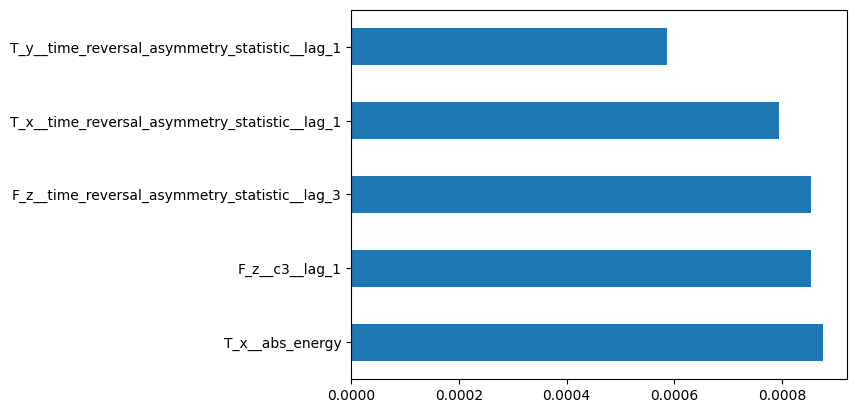

In [97]:
# (1) 특징 추출 데이터
feature_importances = pd.Series(np.abs(lr_clf.coef_[0]),
                                index=comprehensive_features_train.columns)
feature_importances.nlargest(5).plot(kind='barh')

<Axes: >

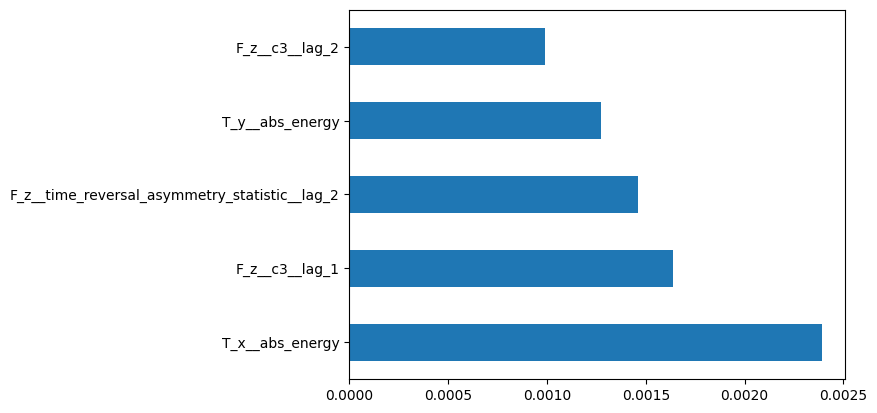

In [96]:
# (2) 특징 추출 및 중요한 특징 위주로 선택한 데이터
feature_importances = pd.Series(np.abs(lr_filtered_clf.coef_[0]),
                                index=filtered_features_train.columns)
feature_importances.nlargest(5).plot(kind='barh')

#### 평가 지표 확인

In [99]:
# (2) 특징 추출 및 중요한 특징 위주로 선택한 데이터
classification_report(y_test, lr_filtered_clf.predict(filtered_features_test), target_names = ['true', 'false'], output_dict = True)

{'true': {'precision': 1.0,
  'recall': 0.5,
  'f1-score': 0.6666666666666666,
  'support': 16},
 'false': {'precision': 0.38461538461538464,
  'recall': 1.0,
  'f1-score': 0.5555555555555556,
  'support': 5},
 'accuracy': 0.6190476190476191,
 'macro avg': {'precision': 0.6923076923076923,
  'recall': 0.75,
  'f1-score': 0.6111111111111112,
  'support': 21},
 'weighted avg': {'precision': 0.8534798534798534,
  'recall': 0.6190476190476191,
  'f1-score': 0.6402116402116401,
  'support': 21}}

### B. Random Forest

#### 학습 및 스코어 확인
1. 특징 추출 데이터: 0.9047619047619048
2. 특징 추출 및 중요한 특징 위주로 선택한 데이터: 1.0

In [110]:
# (1) 특징 추출 데이터

# 학습
rf_clf = RandomForestClassifier(n_estimators=10, max_depth=3, random_state=10)
rf_clf.fit(comprehensive_features_train, y_train)

# 스코어 확인
rf_clf.score(comprehensive_features_test, y_test)

0.9047619047619048

In [111]:
# (2) 특징 추출 및 중요한 특징 위주로 선택한 데이터

# 학습
rf_filtered_clf = RandomForestClassifier(n_estimators=10, max_depth=3, random_state=10)
rf_filtered_clf.fit(filtered_features_train, y_train)

# 스코어 확인
rf_filtered_clf.score(filtered_features_test, y_test)

1.0

#### 특성 중요도 확인
- 중요도 상위 5개 피처 시각화

<Axes: >

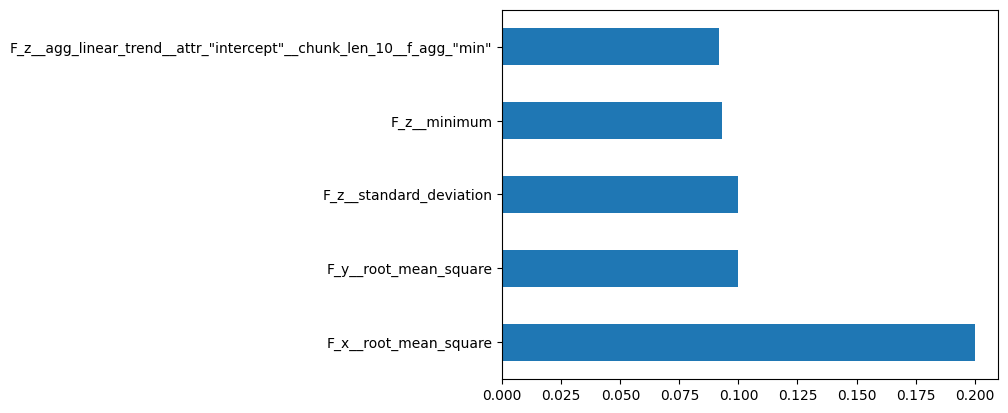

In [66]:
# (1) 특징 추출 데이터
feature_importances = pd.Series(rf_clf.feature_importances_,
                                index=comprehensive_features_train.columns)
feature_importances.nlargest(5).plot(kind='barh')

<Axes: >

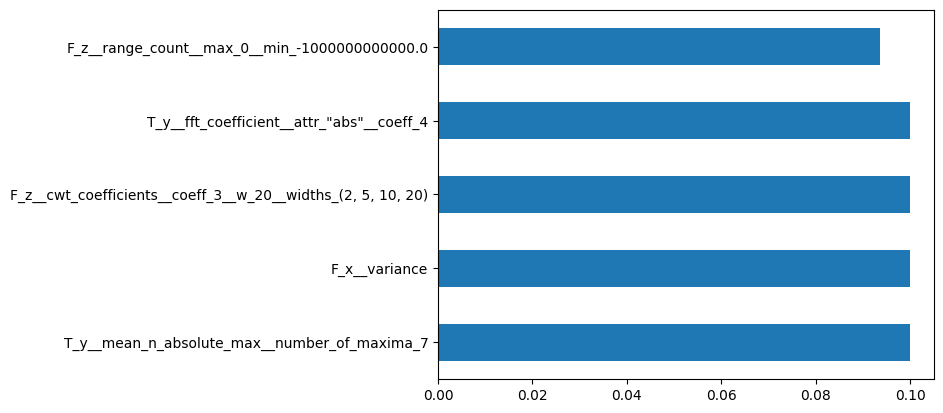

In [115]:
# (2) 특징 추출 및 중요한 특징 위주로 선택한 데이터
feature_importances = pd.Series(rf_filtered_clf.feature_importances_,
                                index=filtered_features_train.columns)
feature_importances.nlargest(5).plot(kind='barh')

#### 평가 지표 확인

In [118]:
# (1) 특징 추출 데이터
classification_report(y_test, rf_clf.predict(comprehensive_features_test), target_names = ['true', 'false'], output_dict = True)

{'true': {'precision': 1.0,
  'recall': 0.875,
  'f1-score': 0.9333333333333333,
  'support': 16},
 'false': {'precision': 0.7142857142857143,
  'recall': 1.0,
  'f1-score': 0.8333333333333333,
  'support': 5},
 'accuracy': 0.9047619047619048,
 'macro avg': {'precision': 0.8571428571428572,
  'recall': 0.9375,
  'f1-score': 0.8833333333333333,
  'support': 21},
 'weighted avg': {'precision': 0.9319727891156463,
  'recall': 0.9047619047619048,
  'f1-score': 0.9095238095238096,
  'support': 21}}

In [119]:
# (2) 특징 추출 및 중요한 특징 위주로 선택한 데이터
classification_report(y_test, rf_filtered_clf.predict(filtered_features_test), target_names = ['true', 'false'], output_dict = True)

{'true': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 16},
 'false': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 5},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 21},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 21}}

### C. XGBoost

#### 학습 및 스코어 확인
1. 특징 추출 데이터: 1.0
2. 특징 추출 및 중요한 특징 위주로 선택한 데이터: 0.95

In [120]:
# (1) 특징 추출 데이터

# 학습
xgb_clf = xgb.XGBClassifier(n_estimators=10, max_depth=3, random_state=10)
xgb_clf.fit(comprehensive_features_train, y_train)

# 스코어 확인
xgb_clf.score(comprehensive_features_test, y_test)

1.0

In [127]:
# (2) 특징 추출 및 중요한 특징 위주로 선택한 데이터

# 학습
xgb_filtered_clf = xgb.XGBClassifier(n_estimators=10, max_depth=3, random_state=10)
xgb_filtered_clf.fit(filtered_features_train, y_train)

# 스코어 확인
xgb_filtered_clf.score(filtered_features_test, y_test)

0.9523809523809523

#### 특성 중요도 확인

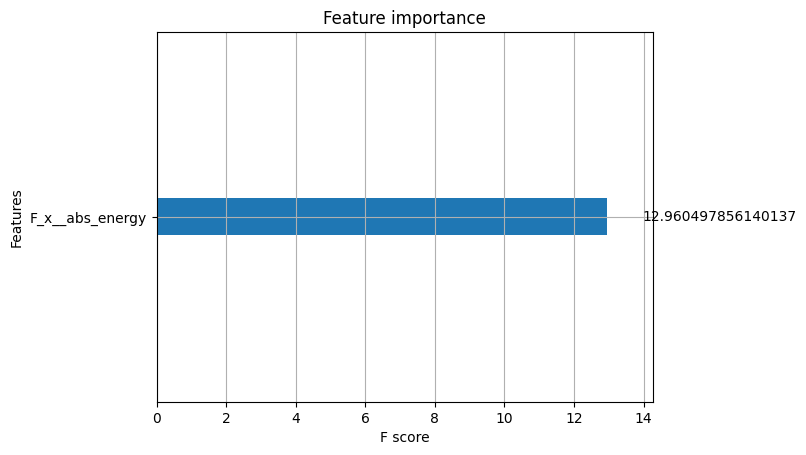

In [45]:
# (1) 특징 추출 데이터
xgb.plot_importance(xgb_clf, importance_type = 'gain')
plt.show()

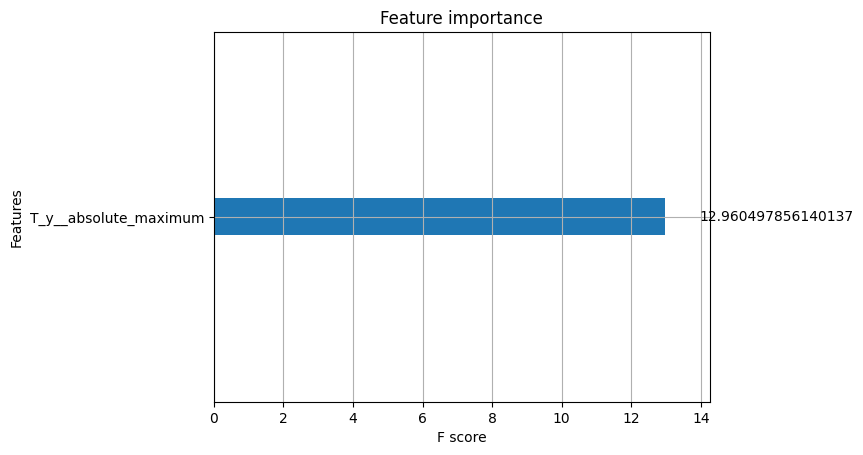

In [128]:
# (2) 특징 추출 및 중요한 특징 위주로 선택한 데이터
xgb.plot_importance(xgb_filtered_clf, importance_type = 'gain')
plt.show()

#### 평가 지표 확인

In [129]:
# (1) 특징 추출 데이터
classification_report(y_test, xgb_clf.predict(comprehensive_features_test), target_names = ['true', 'false'], output_dict = True)

{'true': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 16},
 'false': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 5},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 21},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 21}}

In [130]:
# (2) 특징 추출 및 중요한 특징 위주로 선택한 데이터
classification_report(y_test, xgb_filtered_clf.predict(filtered_features_test), target_names = ['true', 'false'], output_dict = True)

{'true': {'precision': 1.0,
  'recall': 0.9375,
  'f1-score': 0.967741935483871,
  'support': 16},
 'false': {'precision': 0.8333333333333334,
  'recall': 1.0,
  'f1-score': 0.9090909090909091,
  'support': 5},
 'accuracy': 0.9523809523809523,
 'macro avg': {'precision': 0.9166666666666667,
  'recall': 0.96875,
  'f1-score': 0.9384164222873901,
  'support': 21},
 'weighted avg': {'precision': 0.9603174603174603,
  'recall': 0.9523809523809523,
  'f1-score': 0.9537774053903088,
  'support': 21}}

# 회고
- 직접 코드를 작성하니 학습 내용을 정리하는 데 도움이 되었다.